In [ ]:
from google.colab import files
uploaded = files.upload()


Saving videoBTP.mp4 to videoBTP.mp4


In [ ]:
import os
print("Current Working Directory:", os.getcwd())


Current Working Directory: /content


In [ ]:
from google.colab import drive
drive.mount('/content/drive')

In [ ]:
import os
print("Files in current directory:", os.listdir('/content'))


Files in current directory: ['.config', 'frames', 'videoBTP.mp4', 'sample_data']


In [ ]:
import cv2
import os

def extract_frames(video_path, output_folder='frames', frame_rate=30):
    """
    Extract frames from the video and save them to the specified output folder.

    :param video_path: Path to the input video file
    :param output_folder: Folder to save the extracted frames
    :param frame_rate: Frame extraction rate (frames per second)
    """
    if not os.path.exists(video_path):
        print(f"Error: Video file does not exist at {video_path}")
        return

    # Create the output folder if it doesn't exist
    if not os.path.exists(output_folder):
        os.makedirs(output_folder)

    cap = cv2.VideoCapture(video_path)

    if not cap.isOpened():
        print("Error: Could not open video.")
        return

    fps = cap.get(cv2.CAP_PROP_FPS)
    print(f"Video frame rate: {fps} frames per second.")

    frame_count = 0
    frame_num = 0

    while True:
        ret, frame = cap.read()

        if not ret:
            break

        if frame_count % int(fps // frame_rate) == 0:
            frame_filename = os.path.join(output_folder, f'frame_{frame_num:04d}.jpg')
            cv2.imwrite(frame_filename, frame)
            print(f"Saved: {frame_filename}")
            frame_num += 1

        frame_count += 1

    cap.release()
    print("Frame extraction completed.")

video_path = "/content/videoBTP.mp4"


extract_frames(video_path, output_folder='frames', frame_rate=1)


Video frame rate: 25.0 frames per second.
Saved: frames/frame_0000.jpg
Saved: frames/frame_0001.jpg
Saved: frames/frame_0002.jpg
Saved: frames/frame_0003.jpg
Saved: frames/frame_0004.jpg
Saved: frames/frame_0005.jpg
Saved: frames/frame_0006.jpg
Saved: frames/frame_0007.jpg
Saved: frames/frame_0008.jpg
Saved: frames/frame_0009.jpg
Saved: frames/frame_0010.jpg
Saved: frames/frame_0011.jpg
Saved: frames/frame_0012.jpg
Saved: frames/frame_0013.jpg
Saved: frames/frame_0014.jpg
Saved: frames/frame_0015.jpg
Saved: frames/frame_0016.jpg
Saved: frames/frame_0017.jpg
Saved: frames/frame_0018.jpg
Saved: frames/frame_0019.jpg
Saved: frames/frame_0020.jpg
Saved: frames/frame_0021.jpg
Saved: frames/frame_0022.jpg
Saved: frames/frame_0023.jpg
Saved: frames/frame_0024.jpg
Saved: frames/frame_0025.jpg
Saved: frames/frame_0026.jpg
Saved: frames/frame_0027.jpg
Saved: frames/frame_0028.jpg
Saved: frames/frame_0029.jpg
Saved: frames/frame_0030.jpg
Saved: frames/frame_0031.jpg
Saved: frames/frame_0032.jpg
S

In [ ]:
import pandas as pd
import os
import numpy as np
from tensorflow.keras.preprocessing.image import ImageDataGenerator, load_img, img_to_array


frames_dir = '/content/frames'

image_files = [f for f in os.listdir(frames_dir) if f.endswith('.jpg')]

df = pd.DataFrame(image_files, columns=['filename'])


datagen = ImageDataGenerator(rescale=1./255)

def image_generator(df, batch_size=32):
    while True:
        for i in range(0, len(df), batch_size):
            batch_filenames = df['filename'][i:i+batch_size]
            images = []
            for filename in batch_filenames:
                img_path = os.path.join(frames_dir, filename)
                img = load_img(img_path, target_size=(224, 224))  # Resize if needed
                img_array = img_to_array(img)
                images.append(img_array)
            yield np.array(images)

train_gen = image_generator(df)
images = next(train_gen)
print(images.shape)


(32, 224, 224, 3)


In [ ]:
from tensorflow.keras.applications import MobileNetV2
from tensorflow.keras.preprocessing import image
import numpy as np
from tensorflow.keras.applications.mobilenet_v2 import preprocess_input


model = MobileNetV2(weights='imagenet', include_top=False, input_shape=(224, 224, 3))
images_preprocessed = preprocess_input(images)
features = model.predict(images_preprocessed)
print(features.shape)


9406464/9406464 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 3s 3s/step
(32, 7, 7, 1280)


In [ ]:
from tensorflow.keras.models import Model
from tensorflow.keras.layers import GlobalAveragePooling2D, Dense, Dropout
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.applications import MobileNetV2

base_model = MobileNetV2(weights='imagenet', include_top=False, input_shape=(224, 224, 3))

x = base_model.output
x = GlobalAveragePooling2D()(x)
x = Dropout(0.5)(x)
x = Dense(256, activation='relu')(x)
predictions = Dense(26, activation='softmax')(x)

model = Model(inputs=base_model.input, outputs=predictions)


for layer in base_model.layers:
    layer.trainable = False
model.compile(optimizer=Adam(learning_rate=0.0001), loss='categorical_crossentropy', metrics=['accuracy'])
model.summary()


Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)              ┃ Output Shape           ┃        Param # ┃ Connected to           ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━┩
│ input_layer_1             │ (None, 224, 224, 3)    │              0 │ -                      │
│ (InputLayer)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ Conv1 (Conv2D)            │ (None, 112, 112, 32)   │            864 │ input_layer_1[0][0]    │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ bn_Conv1                  │ (None, 112, 112, 32)   │            128 │ Conv1[0][0]            │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ Conv1_relu (ReLU)         │ (None, 112, 112, 32)   │              0 │ bn_Conv1[0][0]         │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ expanded_conv_depthwise   │ (None, 112, 112, 32)   │            288 │ Conv1_relu[0][0]       │
│ (DepthwiseConv2D)         │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ expanded_conv_depthwise_… │ (None, 112, 112, 32)   │            128 │ expanded_conv_depthwi… │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ expanded_conv_depthwise_… │ (None, 112, 112, 32)   │              0 │ expanded_conv_depthwi… │
│ (ReLU)                    │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ expanded_conv_project     │ (None, 112, 112, 16)   │            512 │ expanded_conv_depthwi… │
│ (Conv2D)                  │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ expanded_conv_project_BN  │ (None, 112, 112, 16)   │             64 │ expanded_conv_project… │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ block_1_expand (Conv2D)   │ (None, 112, 112, 96)   │          1,536 │ expanded_conv_project… │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ block_1_expand_BN         │ (None, 112, 112, 96)   │            384 │ block_1_expand[0][0]   │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ block_1_expand_relu       │ (None, 112, 112, 96)   │              0 │ block_1_expand_BN[0][… │
│ (ReLU)                    │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ block_1_pad               │ (None, 113, 113, 96)   │              0 │ block_1_expand_relu[0… │
│ (ZeroPadding2D)           │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ block_1_depthwise         │ (None, 56, 56, 96)     │            864 │ block_1_pad[0][0]      │
│ (DepthwiseConv2D)         │                        │                │                        │
├──────────────────────

 Total params: 2,592,602 (9.89 MB)

 Trainable params: 334,618 (1.28 MB)

 Non-trainable params: 2,257,984 (8.61 MB)

In [ ]:
from google.colab import files
import zipfile
import os

# Upload the dataset zip file
uploaded = files.upload()


Saving asl_alphabet_test.zip to asl_alphabet_test.zip


In [ ]:
import zipfile
import os

zip_file_path = '/content/asl_alphabet_test.zip'
with zipfile.ZipFile(zip_file_path, 'r') as zip_ref:
    zip_ref.extractall('/content/asl_alphabet_test')

extracted_files = os.listdir('/content/asl_alphabet_test')
print(extracted_files)


['asl_alphabet_test']


In [ ]:
import os

extracted_files = os.listdir('/content/asl_alphabet_test/asl_alphabet_test')
print(extracted_files)


['I_test.jpg', 'A_test.jpg', 'P_test.jpg', 'K_test.jpg', 'Y_test.jpg', 'space_test.jpg', 'U_test.jpg', 'Z_test.jpg', 'Q_test.jpg', 'X_test.jpg', 'H_test.jpg', 'R_test.jpg', 'V_test.jpg', 'S_test.jpg', 'L_test.jpg', 'D_test.jpg', 'F_test.jpg', 'G_test.jpg', 'T_test.jpg', 'O_test.jpg', 'J_test.jpg', 'E_test.jpg', 'W_test.jpg', 'C_test.jpg', 'B_test.jpg', 'M_test.jpg', 'nothing_test.jpg', 'N_test.jpg']


In [ ]:
import os

# Check the directory structure of the 'asl_alphabet_test' folder
extracted_files = os.listdir('/content/asl_alphabet_test')
print(extracted_files)


['asl_alphabet_test']


In [ ]:
import os
train_val_dir = '/content/asl_alphabet_test/asl_alphabet_test'
print(os.listdir(train_val_dir))


['I_test.jpg', 'A_test.jpg', 'P_test.jpg', 'K_test.jpg', 'Y_test.jpg', 'space_test.jpg', 'U_test.jpg', 'Z_test.jpg', 'Q_test.jpg', 'X_test.jpg', 'H_test.jpg', 'R_test.jpg', 'V_test.jpg', 'S_test.jpg', 'L_test.jpg', 'D_test.jpg', 'F_test.jpg', 'G_test.jpg', 'T_test.jpg', 'O_test.jpg', 'J_test.jpg', 'E_test.jpg', 'W_test.jpg', 'C_test.jpg', 'B_test.jpg', 'M_test.jpg', 'nothing_test.jpg', 'N_test.jpg']


In [ ]:
import os
import shutil
import random

# Define the source and destination directories
source_dir = '/content/asl_alphabet_test/asl_alphabet_test'
train_dir = '/content/asl_alphabet_test/train'
val_dir = '/content/asl_alphabet_test/val'

# Create train and validation directories
if not os.path.exists(train_dir):
    os.makedirs(train_dir)
if not os.path.exists(val_dir):
    os.makedirs(val_dir)

# List of class labels (A-Z and 'nothing')
labels = ['A', 'B', 'C', 'D', 'E', 'F', 'G', 'H', 'I', 'J', 'K', 'L', 'M', 'N', 'O', 'P', 'Q', 'R', 'S', 'T', 'U', 'V', 'W', 'X', 'Y', 'Z', 'space', 'nothing']

# Create subdirectories for each class in train and validation directories
for label in labels:
    os.makedirs(os.path.join(train_dir, label), exist_ok=True)
    os.makedirs(os.path.join(val_dir, label), exist_ok=True)

# Function to organize images
def organize_images():
    images = os.listdir(source_dir)
    for image in images:
        if not image.endswith('.jpg'):
            continue
        label = image.split('_')[0]  # Extract the label (e.g., 'A', 'B', etc.)
        if label in labels:
            if random.random() < 0.8:
                dest_dir = os.path.join(train_dir, label)
            else:
                dest_dir = os.path.join(val_dir, label)

            # Move the image to the appropriate folder
            shutil.move(os.path.join(source_dir, image), os.path.join(dest_dir, image))

# Organize the images
organize_images()

# Verify that the images are correctly organized
print("Training data directories:", os.listdir(train_dir))
print("Validation data directories:", os.listdir(val_dir))


Training data directories: ['U', 'X', 'T', 'S', 'K', 'J', 'R', 'E', 'B', 'nothing', 'Z', 'F', 'H', 'Y', 'L', 'M', 'D', 'G', 'I', 'P', 'C', 'Q', 'N', 'W', 'space', 'V', 'A', 'O']
Validation data directories: ['U', 'X', 'T', 'S', 'K', 'J', 'R', 'E', 'B', 'nothing', 'Z', 'F', 'H', 'Y', 'L', 'M', 'D', 'G', 'I', 'P', 'C', 'Q', 'N', 'W', 'space', 'V', 'A', 'O']


In [ ]:
import os
train_dir = '/content/frames'
if os.path.isdir(train_dir):
    print("Directory found!")
    for subdir, dirs, files in os.walk(train_dir):
        print(subdir, len(files))
else:
    print("Directory not found.")


Directory found!
/content/frames 40


In [ ]:
import os
import shutil

In [ ]:
import os
import shutil

source_dir = '/content/frames'
output_dir = '/content/frames_sorted'

# List of letters (A to Z)
letters = ['A', 'B', 'C', 'D', 'E', 'F', 'G', 'H', 'I', 'J', 'K', 'L', 'M', 'N', 'O', 'P', 'Q', 'R', 'S', 'T', 'U', 'V', 'W', 'X', 'Y', 'Z']

# Create subdirectories for each letter (A to Z) in the output directory
for letter in letters:
    os.makedirs(os.path.join(output_dir, letter), exist_ok=True)

# List all files in the source directory
files = os.listdir(source_dir)

for file in files:
    # Only process .jpg or .png files
    if file.endswith('.jpg') or file.endswith('.png'):
        # Extract the letter from the filename (assumes the first character of the filename is the letter)
        letter = file[0].upper()  # Convert the first character to uppercase to match the folder names
        if letter in letters:
            # Move the file to the appropriate subdirectory
            shutil.move(os.path.join(source_dir, file), os.path.join(output_dir, letter, file))

print("Files have been reorganized into subdirectories based on their labels.")

Files have been reorganized into subdirectories based on their labels.


In [ ]:
import os
import shutil
import random

# Source directory where all the images are sorted into A-Z subfolders
source_dir = '/content/frames_sorted'

# Create train and validation directories inside frames_sorted
train_dir = os.path.join(source_dir, 'train')
val_dir = os.path.join(source_dir, 'val')

# Create the directories if they do not exist
os.makedirs(train_dir, exist_ok=True)
os.makedirs(val_dir, exist_ok=True)

# Create subdirectories for each class inside train and val directories
letters = ['A', 'B', 'C', 'D', 'E', 'F', 'G', 'H', 'I', 'J', 'K', 'L', 'M', 'N', 'O', 'P', 'Q', 'R', 'S', 'T', 'U', 'V', 'W', 'X', 'Y', 'Z']

for letter in letters:
    os.makedirs(os.path.join(train_dir, letter), exist_ok=True)
    os.makedirs(os.path.join(val_dir, letter), exist_ok=True)

# Now, let's split the files from the source directory into train and val directories
for letter in letters:
    # Get all the image files for the current letter class
    files = os.listdir(os.path.join(source_dir, letter))
    files = [f for f in files if f.endswith('.jpg') or f.endswith('.png')]  # Filter for image files

    # Shuffle the files randomly for splitting
    random.shuffle(files)

    # Split into 80% train and 20% validation (you can adjust the ratio as needed)
    split_index = int(0.8 * len(files))  # 80% for training

    train_files = files[:split_index]
    val_files = files[split_index:]

    # Move the train files
    for file in train_files:
        shutil.move(os.path.join(source_dir, letter, file), os.path.join(train_dir, letter, file))

    # Move the validation files
    for file in val_files:
        shutil.move(os.path.join(source_dir, letter, file), os.path.join(val_dir, letter, file))

print("Files have been split into training and validation directories.")


Files have been split into training and validation directories.


In [ ]:
import os
import shutil
import random


source_dir = '/content/frames'
train_dir = '/content/frames_sorted/train'
val_dir = '/content/frames_sorted/val'

letters = ['A', 'B', 'C', 'D', 'E', 'F', 'G', 'H', 'I', 'J', 'K', 'L', 'M', 'N', 'O', 'P', 'Q', 'R', 'S', 'T', 'U', 'V', 'W', 'X', 'Y', 'Z']
for letter in letters:
    os.makedirs(os.path.join(train_dir, letter), exist_ok=True)
    os.makedirs(os.path.join(val_dir, letter), exist_ok=True)

# Get all the files in the source directory and organize them by class
files = os.listdir(source_dir)
for file in files:
    if file.endswith('.jpg') or file.endswith('.png'):
        class_name = file[0].upper()
        if class_name in letters:
            if random.random() < 0.8:
                shutil.move(os.path.join(source_dir, file), os.path.join(train_dir, class_name, file))
            else:
                shutil.move(os.path.join(source_dir, file), os.path.join(val_dir, class_name, file))

print("Images have been assigned to train and val directories.")


Images have been assigned to train and val directories.


In [ ]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout
from tensorflow.keras.optimizers import Adam
import os

# Set the image size and number of classes
img_size = (224, 224)
train_dir = '/content/frames_sorted/train'
val_dir = '/content/frames_sorted/val'


train_datagen = ImageDataGenerator(rescale=1./255, rotation_range=30, width_shift_range=0.2,
                                   height_shift_range=0.2, shear_range=0.2, zoom_range=0.2,
                                   horizontal_flip=True, fill_mode='nearest')
val_datagen = ImageDataGenerator(rescale=1./255)

train_generator = train_datagen.flow_from_directory(
    train_dir,
    target_size=img_size,
    batch_size=32,
    class_mode='categorical'
)

val_generator = val_datagen.flow_from_directory(
    val_dir,
    target_size=img_size,
    batch_size=32,
    class_mode='categorical'
)

model = Sequential([
    Conv2D(32, (3, 3), activation='relu', input_shape=(224, 224, 3)),
    MaxPooling2D(2, 2),
    Conv2D(64, (3, 3), activation='relu'),
    MaxPooling2D(2, 2),
    Conv2D(128, (3, 3), activation='relu'),
    MaxPooling2D(2, 2),
    Flatten(),
    Dense(512, activation='relu'),
    Dropout(0.5),
    Dense(train_generator.num_classes, activation='softmax')


model.compile(optimizer=Adam(), loss='categorical_crossentropy', metrics=['accuracy'])


history = model.fit(
    train_generator,
    epochs=10,
    validation_data=val_generator
)


test_loss, test_acc = model.evaluate(val_generator)
print(f"Test Accuracy: {test_acc}")
print(f"Test Loss: {test_loss}")


Found 32 images belonging to 26 classes.
Found 8 images belonging to 26 classes.
Epoch 1/10


/usr/local/lib/python3.10/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


1/1 ━━━━━━━━━━━━━━━━━━━━ 7s 7s/step - accuracy: 0.0000e+00 - loss: 3.2690 - val_accuracy: 1.0000 - val_loss: 1.5430e-04
Epoch 2/10
1/1 ━━━━━━━━━━━━━━━━━━━━ 9s 9s/step - accuracy: 1.0000 - loss: 0.0035 - val_accuracy: 1.0000 - val_loss: 0.0000e+00
Epoch 3/10
1/1 ━━━━━━━━━━━━━━━━━━━━ 6s 6s/step - accuracy: 1.0000 - loss: 4.9919e-07 - val_accuracy: 1.0000 - val_loss: 0.0000e+00
Epoch 4/10
1/1 ━━━━━━━━━━━━━━━━━━━━ 4s 4s/step - accuracy: 1.0000 - loss: 0.0000e+00 - val_accuracy: 1.0000 - val_loss: 0.0000e+00
Epoch 5/10
1/1 ━━━━━━━━━━━━━━━━━━━━ 5s 5s/step - accuracy: 1.0000 - loss: 0.0000e+00 - val_accuracy: 1.0000 - val_loss: 0.0000e+00
Epoch 6/10
1/1 ━━━━━━━━━━━━━━━━━━━━ 7s 7s/step - accuracy: 1.0000 - loss: 0.0000e+00 - val_accuracy: 1.0000 - val_loss: 0.0000e+00
Epoch 7/10
1/1 ━━━━━━━━━━━━━━━━━━━━ 9s 9s/step - accuracy: 1.0000 - loss: 0.0000e+00 - val_accuracy: 1.0000 - val_loss: 0.0000e+00
Epoch 8/10
1/1 ━━━━━━━━━━━━━━━━━━━━ 5s 5s/step - accuracy: 1.0000 - loss: 0.0000e+00 - val_accurac

In [ ]:
import cv2
import os
import numpy as np
from tensorflow.keras.models import load_model

frame_dir = '/content/frames_sorted'

labels = sorted(os.listdir(frame_dir))

model = load_model('/content/sign_language_model.h5')
print(model.summary())
img_size = (224, 224)

cap = cv2.VideoCapture(0)

if not cap.isOpened():
    print("Error: Could not open webcam")
    exit()

while cap.isOpened():
    ret, frame = cap.read()
    if not ret:
        print("Failed to capture frame")
        break

    # Resize frame to the expected input size for the model
    img_resized = cv2.resize(frame, img_size)

    # Preprocess the image if required by the model (e.g., normalization)
    img_normalized = img_resized / 255.0
    img_input = np.expand_dims(img_normalized, axis=0)

    # Predict the label
    prediction = model.predict(img_input)
    predicted_class_index = np.argmax(prediction, axis=1)
    predicted_class_label = labels[predicted_class_index[0]]

    font = cv2.FONT_HERSHEY_SIMPLEX
    cv2.putText(frame, predicted_class_label, (10, 30), font, 1, (255, 0, 0), 2, cv2.LINE_AA)

    cv2.imshow('Frame with Label', frame)

    label_dir = os.path.join(frame_dir, predicted_class_label)
    if not os.path.exists(label_dir):
        os.makedirs(label_dir)

    frame_filename = f"{predicted_class_label}_{str(int(np.random.random() * 10000))}.jpg"
    cv2.imwrite(os.path.join(label_dir, frame_filename), frame)

    print(f"Captured Frame: {frame_filename} with label: {predicted_class_label}")
    if cv2.waitKey(1) & 0xFF == ord('q'):
        break

cap.release()
cv2.destroyAllWindows()


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ conv2d_3 (Conv2D)                    │ (None, 222, 222, 32)        │             896 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_3 (MaxPooling2D)       │ (None, 111, 111, 32)        │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_4 (Conv2D)                    │ (None, 109, 109, 64)        │          18,496 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_4 (MaxPooling2D)       │ (None, 54, 54, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_5 (Conv2D)                    │ (None, 52, 52, 128)         │          73,856 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_5 (MaxPooling2D)       │ (None, 26, 26, 128)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten_1 (Flatten)                  │ (None, 86528)               │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_4 (Dense)                      │ (None, 512)                 │      44,302,848 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_5 (Dense)                      │ (None, 28)                  │          14,364 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 44,410,462 (169.41 MB)

 Trainable params: 44,410,460 (169.41 MB)

 Non-trainable params: 0 (0.00 B)

 Optimizer params: 2 (12.00 B)

None
Error: Could not open webcam


In [ ]:
import cv2
import os
import numpy as np
from tensorflow.keras.models import load_model

# Set up the directories where frames are stored (you can change this path as needed)
frame_dir = '/content/frames_sorted'

labels = sorted(os.listdir(frame_dir))

# Load your pre-trained model
model = load_model('/content/sign_language_model.h5')
print(model.summary())

img_size = (224, 224)

cap = cv2.VideoCapture(0)

if not cap.isOpened():
    print("Error: Could not open webcam")
    exit()

while cap.isOpened():
    ret, frame = cap.read()
    if not ret:
        print("Failed to capture frame")
        break

    img_resized = cv2.resize(frame, img_size)

    img_normalized = img_resized / 255.0
    img_input = np.expand_dims(img_normalized, axis=0)
    prediction = model.predict(img_input)
    print("Prediction:", prediction)
    predicted_class_index = np.argmax(prediction, axis=1)
    print("Predicted Class Index:", predicted_class_index)
    predicted_class_label = labels[predicted_class_index[0]]
    print("Predicted Class Label:", predicted_class_label)

    # Display the frame with the label (A-Z)
    font = cv2.FONT_HERSHEY_SIMPLEX
    cv2.putText(frame, predicted_class_label, (10, 30), font, 1, (255, 0, 0), 2, cv2.LINE_AA)

    # Show the frame with the label
    cv2.imshow('Frame with Label', frame)
    cv2.waitKey(1)

    label_dir = os.path.join(frame_dir, predicted_class_label)
    if not os.path.exists(label_dir):
        os.makedirs(label_dir)

    frame_filename = f"{predicted_class_label}_{str(int(np.random.random() * 10000))}.jpg"
    print(f"Saving frame to {os.path.join(label_dir, frame_filename)}")
    cv2.imwrite(os.path.join(label_dir, frame_filename), frame)

    print(f"Captured Frame: {frame_filename} with label: {predicted_class_label}")

    # Press 'q' to quit the loop
    if cv2.waitKey(1) & 0xFF == ord('q'):
        break

cap.release()
cv2.destroyAllWindows()


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ conv2d_3 (Conv2D)                    │ (None, 222, 222, 32)        │             896 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_3 (MaxPooling2D)       │ (None, 111, 111, 32)        │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_4 (Conv2D)                    │ (None, 109, 109, 64)        │          18,496 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_4 (MaxPooling2D)       │ (None, 54, 54, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_5 (Conv2D)                    │ (None, 52, 52, 128)         │          73,856 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_5 (MaxPooling2D)       │ (None, 26, 26, 128)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten_1 (Flatten)                  │ (None, 86528)               │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_4 (Dense)                      │ (None, 512)                 │      44,302,848 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_5 (Dense)                      │ (None, 28)                  │          14,364 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 44,410,462 (169.41 MB)

 Trainable params: 44,410,460 (169.41 MB)

 Non-trainable params: 0 (0.00 B)

 Optimizer params: 2 (12.00 B)

None
Error: Could not open webcam


In [ ]:
import cv2
import os
import numpy as np
from tensorflow.keras.models import load_model
from tensorflow.keras.preprocessing import image


model = load_model('/content/sign_language_model.h5')

class_labels = {0: 'A', 1: 'B', 2: 'C', 3: 'D', 4: 'E', 5: 'F',
                6: 'G', 7: 'H', 8: 'I', 9: 'J', 10: 'K', 11: 'L',
                12: 'M', 13: 'N', 14: 'O', 15: 'P', 16: 'Q', 17: 'R',
                18: 'S', 19: 'T', 20: 'U', 21: 'V', 22: 'W', 23: 'X',
                24: 'Y', 25: 'Z'}

def extract_frames(video_path, output_dir, frame_rate=30):
    if not os.path.exists(video_path):
        print(f"Error: Video file '{video_path}' not found.")
        return
    cap = cv2.VideoCapture(video_path)

    if not cap.isOpened():
        print("Error opening video stream or file")
        return
    if not os.path.exists(output_dir):
        os.makedirs(output_dir)
        print(f"Output directory '{output_dir}' created.")

    frame_count = 0
    while True:
        ret, frame = cap.read()
        if not ret:
            break
        if frame_count % frame_rate == 0:
            frame_filename = os.path.join(output_dir, f"frame_{frame_count}.jpg")
            cv2.imwrite(frame_filename, frame)
        frame_count += 1

    cap.release()
    print(f"Frames saved to {output_dir}")


def preprocess_frame(frame_path, target_size=(224, 224)):
    img = image.load_img(frame_path, target_size=target_size)
    img_array = image.img_to_array(img)
    img_array = np.expand_dims(img_array, axis=0)
    img_array /= 255.0
    return img_array

def predict_from_video(model, video_path, output_dir, frame_rate=30):

    extract_frames(video_path, output_dir, frame_rate)

    predictions = []
    for frame_filename in os.listdir(output_dir):
        frame_path = os.path.join(output_dir, frame_filename)
        img_array = preprocess_frame(frame_path)
        prediction = model.predict(img_array)

        print(f"Raw Prediction: {prediction}")


        predicted_class = np.argmax(prediction, axis=-1)


        print(f"Predicted Class Index: {predicted_class}")


        predictions.append(predicted_class[0])

        predicted_gesture = class_labels.get(predicted_class[0], "Unknown")
        print(f"Frame {frame_filename}: Predicted gesture - {predicted_gesture}")


    aggregated_prediction = aggregate_predictions(predictions)
    final_predicted_gesture = class_labels.get(aggregated_prediction, "Unknown")
    print(f"Final Predicted Gesture: {final_predicted_gesture}")


def aggregate_predictions(predictions):
    return max(set(predictions), key=predictions.count)


video_path = r'/content/videoBTP.mp4'
output_dir = 'extracted_frames'

# Run the prediction process
predict_from_video(model, video_path, output_dir, frame_rate=30)


Frames saved to extracted_frames
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 141ms/step
Raw Prediction: [[6.7088078e-04 3.1880194e-03 5.8115456e-06 3.3840775e-01 5.5681258e-03
  2.2630258e-02 2.7633926e-02 3.9663132e-06 2.2387287e-02 2.4595492e-02
  1.4784926e-01 1.2386383e-02 6.1542853e-03 1.0222269e-05 1.3832099e-02
  3.5671877e-05 4.5823348e-03 2.2772899e-01 1.3590468e-02 4.1612651e-02
  9.7277325e-07 3.0635631e-05 5.6316634e-03 2.5668865e-02 1.3971630e-02
  3.7510993e-06 3.6841176e-02 4.9773604e-03]]
Predicted Class Index: [3]
Frame frame_90.jpg: Predicted gesture - D
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 88ms/step
Raw Prediction: [[3.0674305e-04 6.6246358e-03 4.7041308e-06 4.5062065e-01 5.4707220e-03
  4.3204725e-02 2.7233519e-02 2.5483930e-06 1.7469555e-02 9.7427368e-03
  1.6035372e-01 6.9295112e-03 5.6327847e-03 6.6313069e-06 8.0770683e-03
  2.4105657e-05 2.9282903e-03 1.5094945e-01 1.0273410e-02 3.7224345e-02
  6.5563842e-07 1.9819754e-05 4.5610676e-03 1.0234143e-02 1.0262207e-02
  2.4980970e-06 2.76840

In [ ]:
import cv2
import os
import numpy as np
from tensorflow.keras.models import load_model
from tensorflow.keras.preprocessing import image


model = load_model('/content/sign_language_model.h5')

class_labels = {0: 'A', 1: 'B', 2: 'C', 3: 'D', 4: 'E', 5: 'F',
                6: 'G', 7: 'H', 8: 'I', 9: 'J', 10: 'K', 11: 'L',
                12: 'M', 13: 'N', 14: 'O', 15: 'P', 16: 'Q', 17: 'R',
                18: 'S', 19: 'T', 20: 'U', 21: 'V', 22: 'W', 23: 'X',
                24: 'Y', 25: 'Z'}

def extract_frames(video_path, output_dir, frame_rate=30):
    if not os.path.exists(video_path):
        print(f"Error: Video file '{video_path}' not found.")
        return

    cap = cv2.VideoCapture(video_path)

    if not cap.isOpened():
        print("Error opening video stream or file")
        return

    if not os.path.exists(output_dir):
        os.makedirs(output_dir)
        print(f"Output directory '{output_dir}' created.")

    frame_count = 0
    while True:
        ret, frame = cap.read()
        if not ret:
            break

        if frame_count % frame_rate == 0:
            frame_filename = os.path.join(output_dir, f"frame_{frame_count}.jpg")
            cv2.imwrite(frame_filename, frame)
        frame_count += 1

    cap.release()
    print(f"Frames saved to {output_dir}")

def preprocess_frame(frame_path, target_size=(224, 224)):
    img = image.load_img(frame_path, target_size=target_size)
    img_array = image.img_to_array(img)
    img_array = np.expand_dims(img_array, axis=0)
    img_array /= 255.0  # Rescale the image
    return img_array

def predict_from_video(model, video_path, output_dir, frame_rate=30):
    extract_frames(video_path, output_dir, frame_rate)

    predictions = []
    for frame_filename in os.listdir(output_dir):
        frame_path = os.path.join(output_dir, frame_filename)

        img_array = preprocess_frame(frame_path)
        prediction = model.predict(img_array)
        predicted_class = np.argmax(prediction, axis=-1)
        predictions.append(predicted_class[0])

        predicted_gesture = class_labels.get(predicted_class[0], "Unknown")
        print(f"Frame {frame_filename}: Predicted gesture - {predicted_gesture}")

        frame = cv2.imread(frame_path)
        font = cv2.FONT_HERSHEY_SIMPLEX
        text = f"Predicted: {predicted_gesture}"
        position = (10, 30)
        color = (0, 255, 0)
        font_scale = 1
        thickness = 2
        cv2.putText(frame, text, position, font, font_scale, color, thickness)

        output_frame_path = os.path.join(output_dir, f"predicted_{frame_filename}")
        cv2.imwrite(output_frame_path, frame)

    aggregated_prediction = aggregate_predictions(predictions)
    final_predicted_gesture = class_labels.get(aggregated_prediction, "Unknown")
    print(f"Final Predicted Gesture: {final_predicted_gesture}")

def aggregate_predictions(predictions):
    return max(set(predictions), key=predictions.count)
video_path = r'/content/videoBTP.mp4'
output_dir = 'extracted_frames_with_predictions'

predict_from_video(model, video_path, output_dir, frame_rate=30)


Output directory 'extracted_frames_with_predictions' created.
Frames saved to extracted_frames_with_predictions
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 115ms/step
Frame frame_90.jpg: Predicted gesture - D
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 67ms/step
Frame frame_720.jpg: Predicted gesture - D
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 59ms/step
Frame frame_570.jpg: Predicted gesture - D
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 77ms/step
Frame frame_810.jpg: Predicted gesture - D
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 88ms/step
Frame frame_840.jpg: Predicted gesture - D
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 87ms/step
Frame frame_870.jpg: Predicted gesture - D
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 96ms/step
Frame frame_0.jpg: Predicted gesture - D
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 100ms/step
Frame frame_480.jpg: Predicted gesture - D
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 90ms/step
Frame frame_420.jpg: Predicted gesture - D
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 90ms/step
Frame frame_450.jpg: Predicted gesture - D
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 99ms/step
Frame frame_390.jpg: Predicted gesture - 

In [ ]:
import cv2
import os
import numpy as np
from tensorflow.keras.models import load_model
from tensorflow.keras.preprocessing import image

# Load the trained model
model = load_model('/content/sign_language_model.h5')

class_labels = {0: 'A', 1: 'B', 2: 'C', 3: 'D', 4: 'E', 5: 'F',
                6: 'G', 7: 'H', 8: 'I', 9: 'J', 10: 'K', 11: 'L',
                12: 'M', 13: 'N', 14: 'O', 15: 'P', 16: 'Q', 17: 'R',
                18: 'S', 19: 'T', 20: 'U', 21: 'V', 22: 'W', 23: 'X',
                24: 'Y', 25: 'Z'}


def extract_frames(video_path, output_dir, frame_rate=30):
    if not os.path.exists(video_path):
        print(f"Error: Video file '{video_path}' not found.")
        return

    cap = cv2.VideoCapture(video_path)

    if not cap.isOpened():
        print("Error opening video stream or file")
        return

    if not os.path.exists(output_dir):
        os.makedirs(output_dir)
        print(f"Output directory '{output_dir}' created.")

    frame_count = 0
    while True:
        ret, frame = cap.read()
        if not ret:
            break

        # Save frames at a specified frame rate
        if frame_count % frame_rate == 0:
            frame_filename = os.path.join(output_dir, f"frame_{frame_count}.jpg")
            cv2.imwrite(frame_filename, frame)
        frame_count += 1

    cap.release()
    print(f"Frames saved to {output_dir}")

def preprocess_frame(frame_path, target_size=(224, 224)):
    img = image.load_img(frame_path, target_size=target_size)
    img_array = image.img_to_array(img)
    img_array = np.expand_dims(img_array, axis=0)
    img_array /= 255.0
    return img_array

def predict_from_video(model, video_path, output_dir, frame_rate=30):
    # Extract frames from the video
    extract_frames(video_path, output_dir, frame_rate)

    predictions = []
    for frame_filename in os.listdir(output_dir):
        frame_path = os.path.join(output_dir, frame_filename)
        img_array = preprocess_frame(frame_path)
        prediction = model.predict(img_array)
        predicted_class = np.argmax(prediction, axis=-1)
        predictions.append(predicted_class[0])

        predicted_gesture = class_labels.get(predicted_class[0], "Unknown")
        print(f"Frame {frame_filename}: Predicted gesture - {predicted_gesture}")

        frame = cv2.imread(frame_path)
        font = cv2.FONT_HERSHEY_SIMPLEX
        text = f"Predicted: {predicted_gesture}"
        position = (10, 30)
        color = (0, 255, 0)
        font_scale = 1
        thickness = 2

        cv2.putText(frame, text, position, font, font_scale, color, thickness)

        output_frame_path = os.path.join(output_dir, f"predicted_{frame_filename}")
        cv2.imwrite(output_frame_path, frame)

    aggregated_prediction = aggregate_predictions(predictions)
    final_predicted_gesture = class_labels.get(aggregated_prediction, "Unknown")
    print(f"Final Predicted Gesture: {final_predicted_gesture}")

def aggregate_predictions(predictions):
    return max(set(predictions), key=predictions.count)

video_path = r'/content/videoBTP.mp4'
output_dir = 'extracted_frames_with_predictions'

predict_from_video(model, video_path, output_dir, frame_rate=30)


Frames saved to extracted_frames_with_predictions
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 123ms/step
Frame predicted_frame_0.jpg: Predicted gesture - R
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 57ms/step
Frame frame_90.jpg: Predicted gesture - D
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 60ms/step
Frame frame_720.jpg: Predicted gesture - D
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 60ms/step
Frame frame_570.jpg: Predicted gesture - D
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 59ms/step
Frame frame_810.jpg: Predicted gesture - D
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 64ms/step
Frame frame_840.jpg: Predicted gesture - D
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 91ms/step
Frame predicted_frame_30.jpg: Predicted gesture - R
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 90ms/step
Frame predicted_frame_390.jpg: Predicted gesture - R
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 90ms/step
Frame frame_870.jpg: Predicted gesture - D
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 97ms/step
Frame frame_0.jpg: Predicted gesture - D
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 92ms/step
Frame predicted_frame_600.jpg: Predicted gesture - R
1/1 ━━━━━━━━━━━━━━━━━━━━

Frames saved to extracted_frames_with_predictions
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 56ms/step
Frame predicted_predicted_frame_540.jpg: Predicted gesture - R


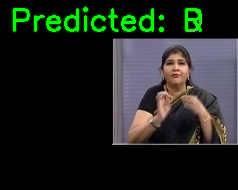

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 64ms/step
Frame predicted_predicted_frame_300.jpg: Predicted gesture - R


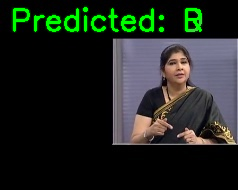

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 59ms/step
Frame predicted_predicted_frame_390.jpg: Predicted gesture - R


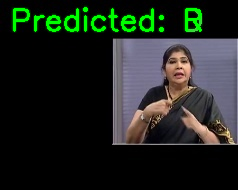

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 85ms/step
Frame predicted_predicted_frame_960.jpg: Predicted gesture - R


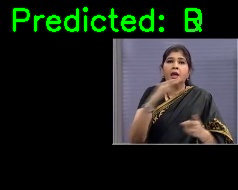

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 58ms/step
Frame predicted_frame_0.jpg: Predicted gesture - R


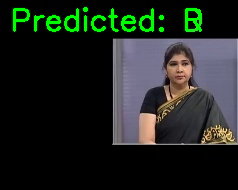

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 56ms/step
Frame predicted_predicted_predicted_frame_900.jpg: Predicted gesture - R


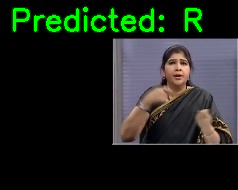

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 56ms/step
Frame frame_90.jpg: Predicted gesture - D


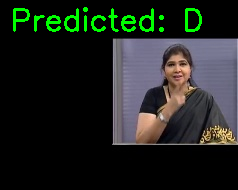

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 65ms/step
Frame predicted_predicted_predicted_frame_780.jpg: Predicted gesture - R


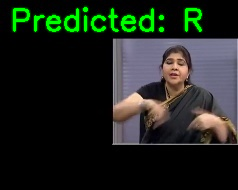

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 61ms/step
Frame frame_720.jpg: Predicted gesture - D


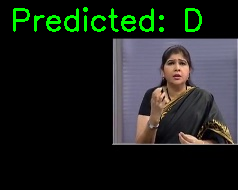

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 57ms/step
Frame predicted_predicted_predicted_frame_840.jpg: Predicted gesture - R


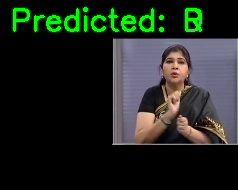

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 66ms/step
Frame predicted_predicted_frame_690.jpg: Predicted gesture - R


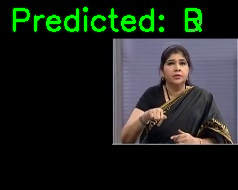

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 62ms/step
Frame frame_570.jpg: Predicted gesture - D


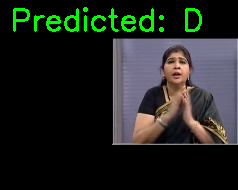

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 56ms/step
Frame frame_810.jpg: Predicted gesture - D


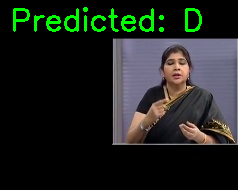

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 57ms/step
Frame frame_840.jpg: Predicted gesture - D


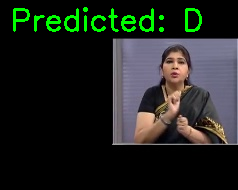

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 57ms/step
Frame predicted_predicted_predicted_frame_450.jpg: Predicted gesture - R


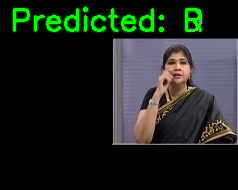

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 56ms/step
Frame predicted_frame_30.jpg: Predicted gesture - R


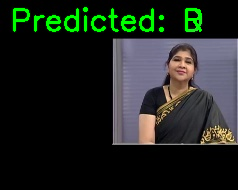

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 60ms/step
Frame predicted_predicted_frame_510.jpg: Predicted gesture - R


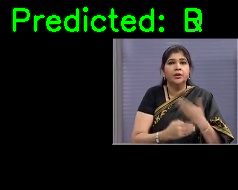

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 62ms/step
Frame predicted_predicted_frame_0.jpg: Predicted gesture - R


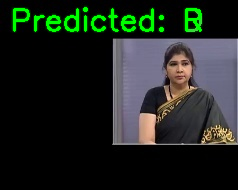

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 64ms/step
Frame predicted_predicted_predicted_frame_270.jpg: Predicted gesture - R


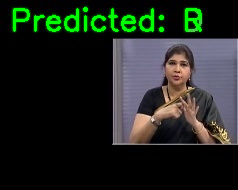

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 57ms/step
Frame predicted_predicted_predicted_frame_570.jpg: Predicted gesture - R


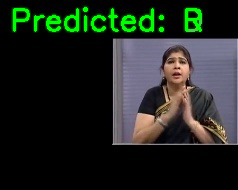

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 59ms/step
Frame predicted_frame_390.jpg: Predicted gesture - R


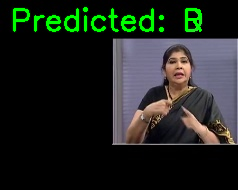

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 60ms/step
Frame predicted_predicted_frame_150.jpg: Predicted gesture - R


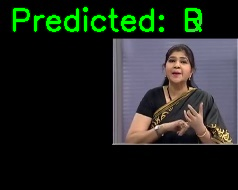

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 60ms/step
Frame frame_870.jpg: Predicted gesture - D


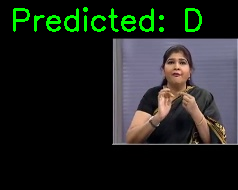

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 59ms/step
Frame predicted_predicted_frame_600.jpg: Predicted gesture - R


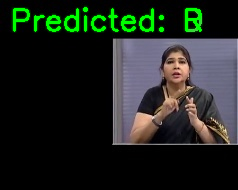

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 67ms/step
Frame frame_0.jpg: Predicted gesture - D


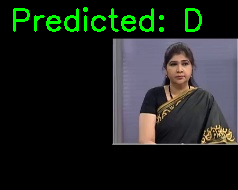

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 94ms/step
Frame predicted_frame_600.jpg: Predicted gesture - R


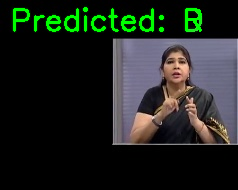

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 71ms/step
Frame predicted_predicted_predicted_frame_60.jpg: Predicted gesture - R


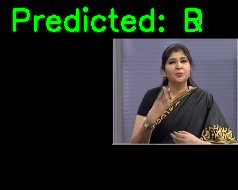

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 107ms/step
Frame predicted_predicted_frame_750.jpg: Predicted gesture - R


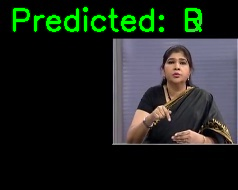

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 58ms/step
Frame predicted_predicted_predicted_frame_330.jpg: Predicted gesture - R


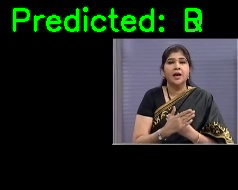

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 87ms/step
Frame predicted_frame_360.jpg: Predicted gesture - R


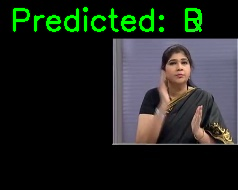

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 125ms/step
Frame frame_480.jpg: Predicted gesture - D


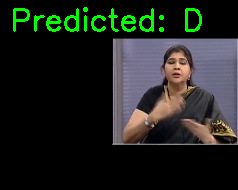

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 94ms/step
Frame predicted_predicted_predicted_frame_480.jpg: Predicted gesture - R


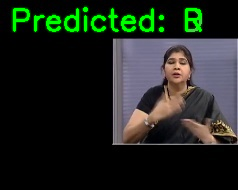

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 100ms/step
Frame predicted_frame_210.jpg: Predicted gesture - R


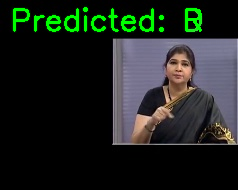

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 112ms/step
Frame predicted_predicted_frame_630.jpg: Predicted gesture - R


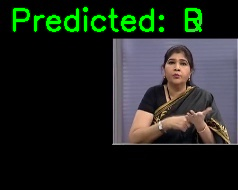

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 139ms/step
Frame predicted_predicted_predicted_frame_930.jpg: Predicted gesture - R


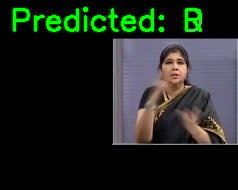

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 106ms/step
Frame predicted_predicted_frame_570.jpg: Predicted gesture - R


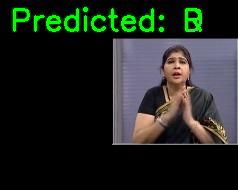

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 134ms/step
Frame predicted_frame_750.jpg: Predicted gesture - R


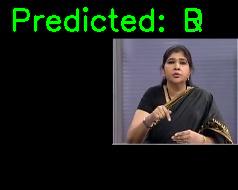

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 141ms/step
Frame predicted_frame_240.jpg: Predicted gesture - R


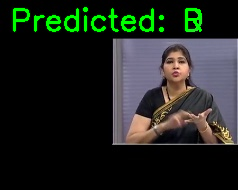

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 165ms/step
Frame frame_420.jpg: Predicted gesture - D


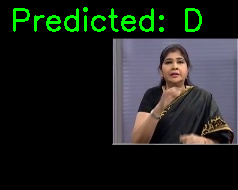

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 131ms/step
Frame frame_450.jpg: Predicted gesture - D


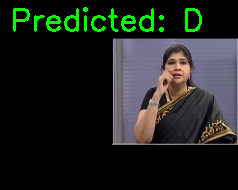

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 101ms/step
Frame frame_390.jpg: Predicted gesture - D


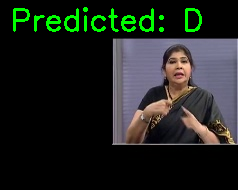

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 131ms/step
Frame predicted_frame_150.jpg: Predicted gesture - R


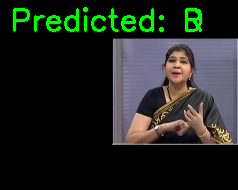

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 143ms/step
Frame predicted_frame_780.jpg: Predicted gesture - R


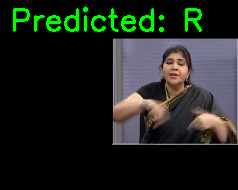

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 140ms/step
Frame predicted_frame_660.jpg: Predicted gesture - R


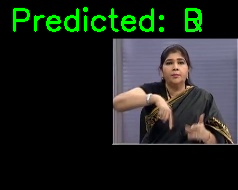

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 90ms/step
Frame predicted_predicted_frame_240.jpg: Predicted gesture - R


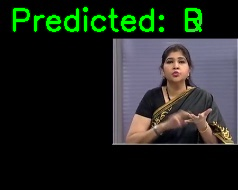

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 159ms/step
Frame predicted_frame_930.jpg: Predicted gesture - R


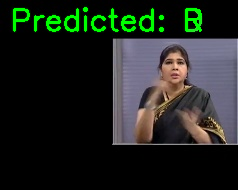

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 141ms/step
Frame predicted_predicted_predicted_frame_390.jpg: Predicted gesture - R


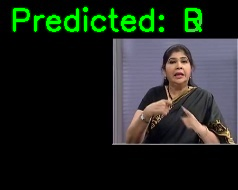

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 131ms/step
Frame predicted_frame_570.jpg: Predicted gesture - R


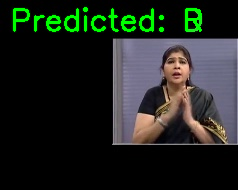

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 169ms/step
Frame predicted_predicted_predicted_frame_0.jpg: Predicted gesture - R


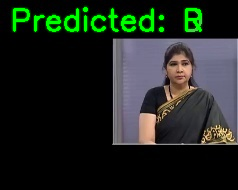

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 110ms/step
Frame predicted_predicted_predicted_frame_660.jpg: Predicted gesture - R


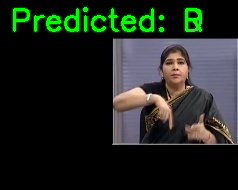

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 125ms/step
Frame predicted_frame_90.jpg: Predicted gesture - R


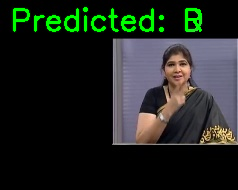

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 101ms/step
Frame predicted_frame_870.jpg: Predicted gesture - R


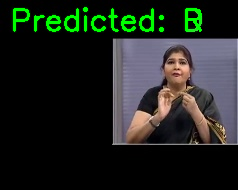

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 92ms/step
Frame frame_150.jpg: Predicted gesture - D


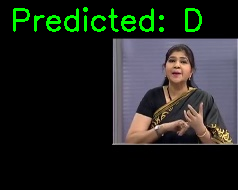

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 89ms/step
Frame predicted_frame_900.jpg: Predicted gesture - R


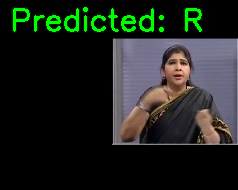

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 89ms/step
Frame frame_120.jpg: Predicted gesture - D


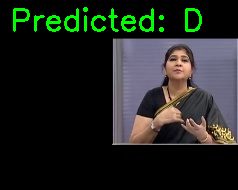

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 97ms/step
Frame frame_240.jpg: Predicted gesture - D


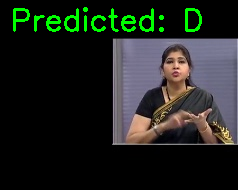

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 100ms/step
Frame predicted_predicted_predicted_frame_690.jpg: Predicted gesture - R


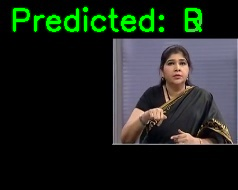

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 102ms/step
Frame frame_660.jpg: Predicted gesture - D


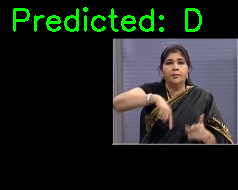

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 91ms/step
Frame predicted_frame_120.jpg: Predicted gesture - R


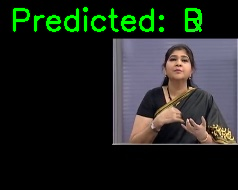

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 99ms/step
Frame frame_330.jpg: Predicted gesture - D


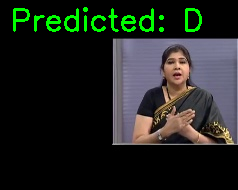

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 92ms/step
Frame predicted_predicted_frame_90.jpg: Predicted gesture - R


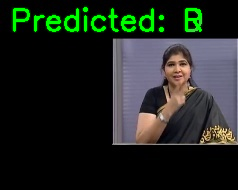

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 91ms/step
Frame predicted_predicted_predicted_frame_750.jpg: Predicted gesture - R


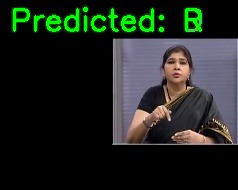

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 90ms/step
Frame predicted_frame_510.jpg: Predicted gesture - R


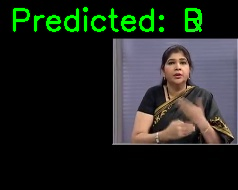

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 92ms/step
Frame predicted_frame_60.jpg: Predicted gesture - R


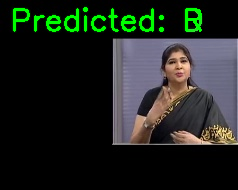

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 90ms/step
Frame predicted_predicted_frame_180.jpg: Predicted gesture - R


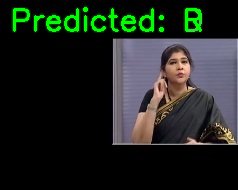

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 90ms/step
Frame predicted_predicted_frame_450.jpg: Predicted gesture - R


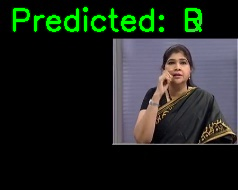

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 102ms/step
Frame predicted_predicted_frame_870.jpg: Predicted gesture - R


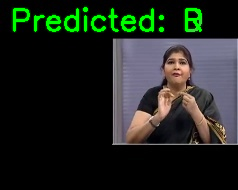

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 104ms/step
Frame frame_750.jpg: Predicted gesture - D


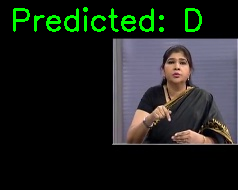

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 103ms/step
Frame predicted_predicted_frame_30.jpg: Predicted gesture - R


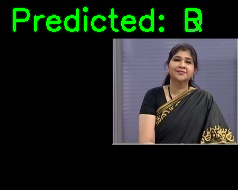

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 98ms/step
Frame predicted_predicted_predicted_frame_210.jpg: Predicted gesture - R


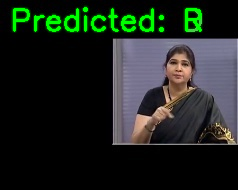

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 88ms/step
Frame frame_60.jpg: Predicted gesture - D


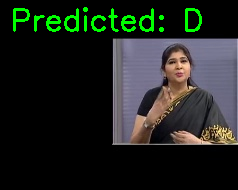

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 91ms/step
Frame predicted_predicted_predicted_frame_540.jpg: Predicted gesture - R


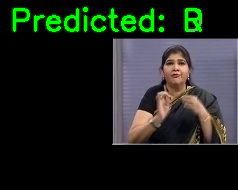

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 109ms/step
Frame frame_600.jpg: Predicted gesture - D


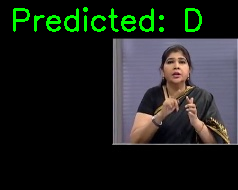

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 85ms/step
Frame predicted_predicted_frame_930.jpg: Predicted gesture - R


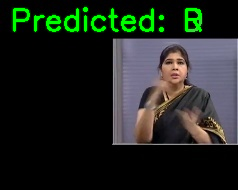

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 91ms/step
Frame predicted_predicted_frame_60.jpg: Predicted gesture - R


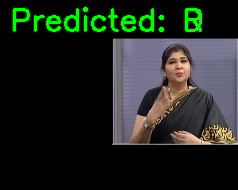

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 90ms/step
Frame predicted_predicted_frame_120.jpg: Predicted gesture - R


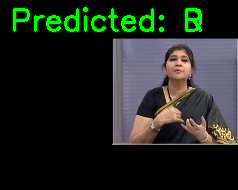

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 117ms/step
Frame predicted_predicted_predicted_frame_810.jpg: Predicted gesture - R


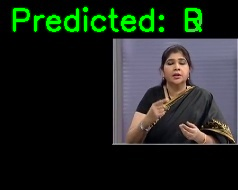

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 96ms/step
Frame predicted_frame_960.jpg: Predicted gesture - R


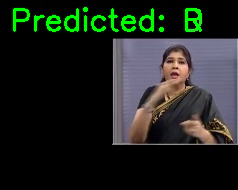

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 89ms/step
Frame frame_180.jpg: Predicted gesture - D


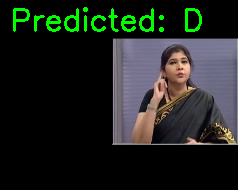

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 96ms/step
Frame frame_690.jpg: Predicted gesture - D


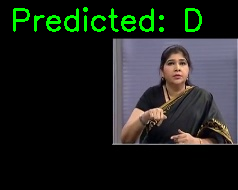

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 96ms/step
Frame frame_780.jpg: Predicted gesture - R


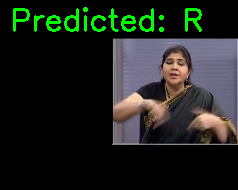

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 91ms/step
Frame predicted_predicted_frame_330.jpg: Predicted gesture - R


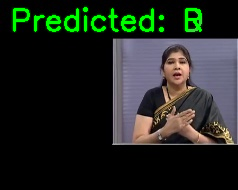

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 90ms/step
Frame predicted_frame_810.jpg: Predicted gesture - R


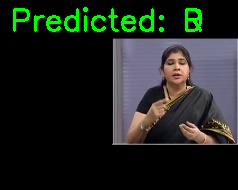

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 91ms/step
Frame predicted_frame_180.jpg: Predicted gesture - R


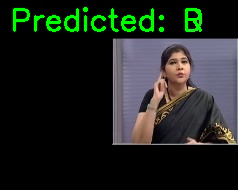

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 91ms/step
Frame predicted_predicted_predicted_frame_960.jpg: Predicted gesture - R


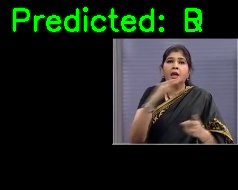

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 99ms/step
Frame predicted_predicted_predicted_frame_150.jpg: Predicted gesture - R


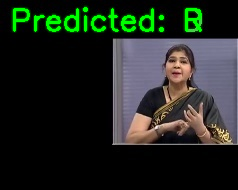

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 98ms/step
Frame predicted_frame_300.jpg: Predicted gesture - R


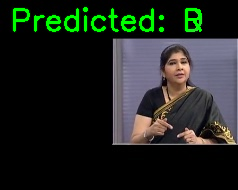

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 87ms/step
Frame predicted_frame_630.jpg: Predicted gesture - R


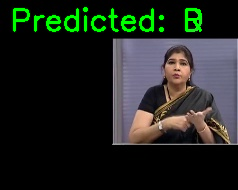

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 123ms/step
Frame predicted_predicted_frame_360.jpg: Predicted gesture - R


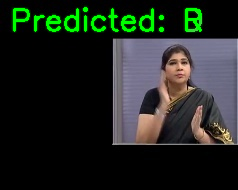

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 94ms/step
Frame predicted_frame_540.jpg: Predicted gesture - R


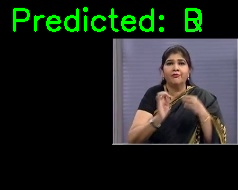

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 90ms/step
Frame predicted_predicted_frame_270.jpg: Predicted gesture - R


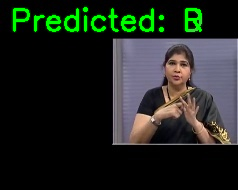

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 93ms/step
Frame predicted_predicted_frame_810.jpg: Predicted gesture - R


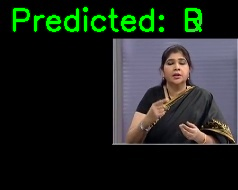

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 121ms/step
Frame predicted_predicted_frame_480.jpg: Predicted gesture - R


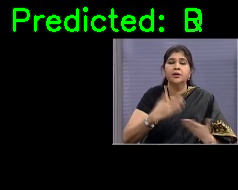

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 90ms/step
Frame predicted_frame_270.jpg: Predicted gesture - R


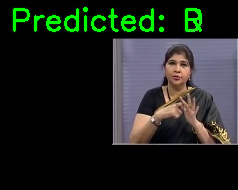

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 105ms/step
Frame predicted_predicted_predicted_frame_870.jpg: Predicted gesture - R


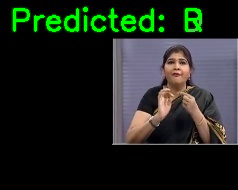

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 90ms/step
Frame predicted_frame_330.jpg: Predicted gesture - R


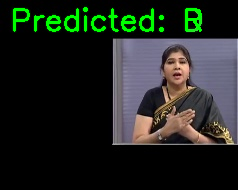

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 98ms/step
Frame predicted_predicted_frame_660.jpg: Predicted gesture - R


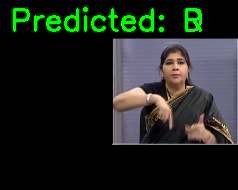

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 91ms/step
Frame predicted_predicted_predicted_frame_180.jpg: Predicted gesture - R


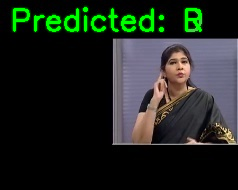

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 92ms/step
Frame predicted_predicted_predicted_frame_240.jpg: Predicted gesture - R


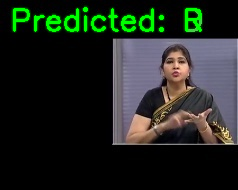

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 94ms/step
Frame predicted_predicted_predicted_frame_510.jpg: Predicted gesture - R


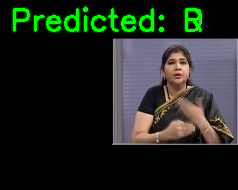

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 103ms/step
Frame predicted_predicted_frame_420.jpg: Predicted gesture - R


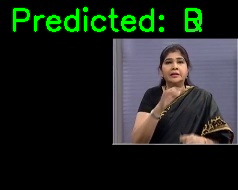

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 90ms/step
Frame frame_510.jpg: Predicted gesture - D


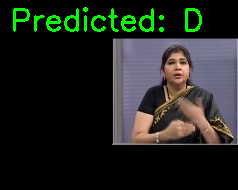

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 95ms/step
Frame predicted_frame_720.jpg: Predicted gesture - R


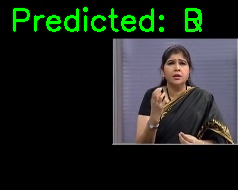

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 126ms/step
Frame predicted_frame_480.jpg: Predicted gesture - R


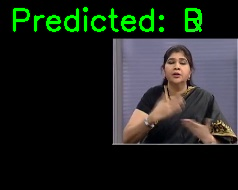

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 101ms/step
Frame frame_300.jpg: Predicted gesture - D


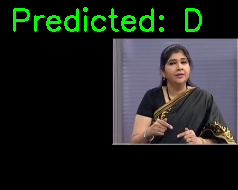

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 100ms/step
Frame predicted_predicted_predicted_frame_300.jpg: Predicted gesture - R


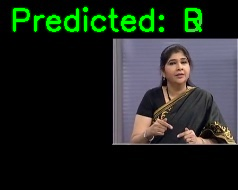

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 120ms/step
Frame predicted_predicted_predicted_frame_420.jpg: Predicted gesture - R


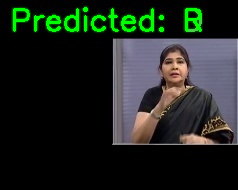

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 124ms/step
Frame frame_210.jpg: Predicted gesture - D


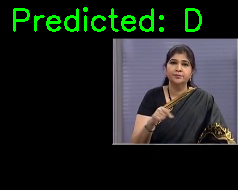

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 116ms/step
Frame frame_630.jpg: Predicted gesture - D


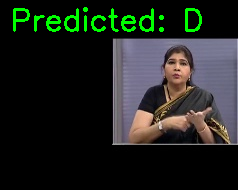

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 134ms/step
Frame predicted_predicted_predicted_frame_120.jpg: Predicted gesture - R


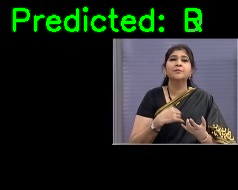

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 130ms/step
Frame predicted_predicted_frame_780.jpg: Predicted gesture - R


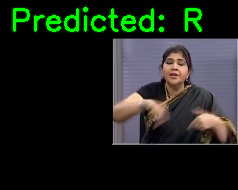

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 157ms/step
Frame predicted_predicted_frame_210.jpg: Predicted gesture - R


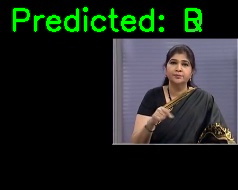

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 134ms/step
Frame predicted_predicted_predicted_frame_600.jpg: Predicted gesture - R


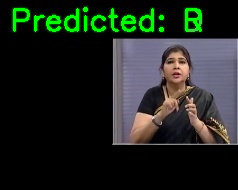

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 162ms/step
Frame frame_30.jpg: Predicted gesture - D


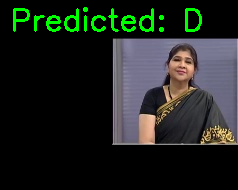

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 134ms/step
Frame frame_900.jpg: Predicted gesture - R


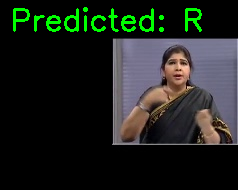

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 139ms/step
Frame frame_360.jpg: Predicted gesture - D


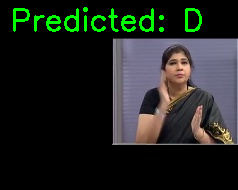

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 106ms/step
Frame predicted_predicted_predicted_frame_720.jpg: Predicted gesture - R


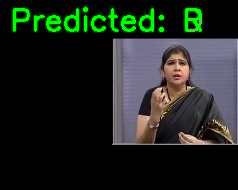

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 98ms/step
Frame frame_270.jpg: Predicted gesture - D


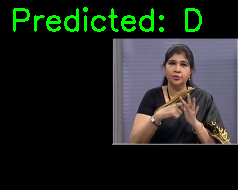

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 106ms/step
Frame predicted_frame_450.jpg: Predicted gesture - R


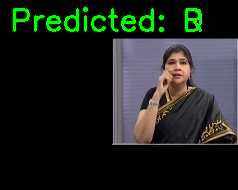

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 152ms/step
Frame predicted_predicted_predicted_frame_30.jpg: Predicted gesture - R


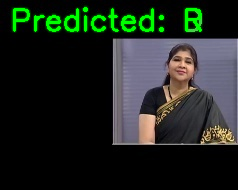

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 123ms/step
Frame frame_960.jpg: Predicted gesture - D


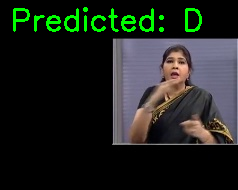

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 170ms/step
Frame predicted_frame_690.jpg: Predicted gesture - R


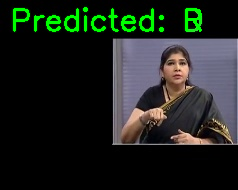

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 167ms/step
Frame frame_540.jpg: Predicted gesture - D


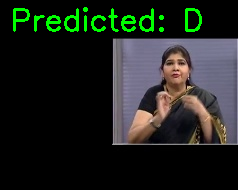

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 123ms/step
Frame predicted_frame_420.jpg: Predicted gesture - R


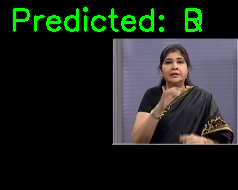

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 128ms/step
Frame predicted_predicted_frame_900.jpg: Predicted gesture - R


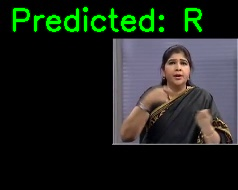

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 125ms/step
Frame predicted_predicted_predicted_frame_360.jpg: Predicted gesture - R


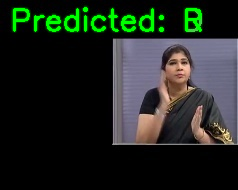

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 88ms/step
Frame predicted_predicted_frame_720.jpg: Predicted gesture - R


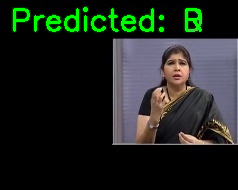

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 94ms/step
Frame predicted_frame_840.jpg: Predicted gesture - R


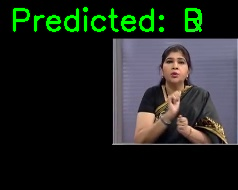

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 99ms/step
Frame predicted_predicted_frame_840.jpg: Predicted gesture - R


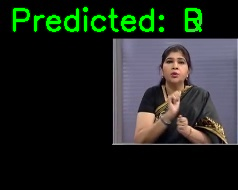

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 103ms/step
Frame predicted_predicted_predicted_frame_90.jpg: Predicted gesture - R


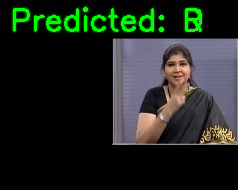

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 104ms/step
Frame frame_930.jpg: Predicted gesture - D


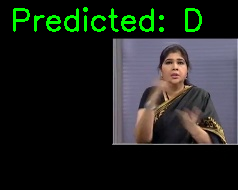

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 88ms/step
Frame predicted_predicted_predicted_frame_630.jpg: Predicted gesture - R


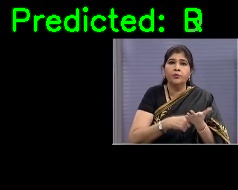

Final Predicted Gesture: R


In [ ]:
from google.colab.patches import cv2_imshow

def predict_from_video(model, video_path, output_dir, frame_rate=30):
    extract_frames(video_path, output_dir, frame_rate)

    predictions = []
    for frame_filename in os.listdir(output_dir):
        frame_path = os.path.join(output_dir, frame_filename)

        img_array = preprocess_frame(frame_path)

        prediction = model.predict(img_array)

        predicted_class = np.argmax(prediction, axis=-1)

        predictions.append(predicted_class[0])

        predicted_gesture = class_labels.get(predicted_class[0], "Unknown")
        print(f"Frame {frame_filename}: Predicted gesture - {predicted_gesture}")

        frame = cv2.imread(frame_path)

        font = cv2.FONT_HERSHEY_SIMPLEX
        text = f"Predicted: {predicted_gesture}"
        position = (10, 30)
        color = (0, 255, 0)
        font_scale = 1
        thickness = 2
        cv2.putText(frame, text, position, font, font_scale, color, thickness)
        cv2_imshow(frame)

        cv2.waitKey(0)

    aggregated_prediction = aggregate_predictions(predictions)
    final_predicted_gesture = class_labels.get(aggregated_prediction, "Unknown")
    print(f"Final Predicted Gesture: {final_predicted_gesture}")


video_path = r'/content/videoBTP.mp4'
output_dir = 'extracted_frames_with_predictions'

predict_from_video(model, video_path, output_dir, frame_rate=30)


In [ ]:
import cv2
import os
import numpy as np
from tensorflow.keras.models import load_model

frame_dir = '/content/frames_sorted'

labels = sorted(os.listdir(frame_dir))

model = load_model('/content/sign_language_model.h5')
print(model.summary())

img_size = (224, 224)

cap = cv2.VideoCapture(0)

if not cap.isOpened():
    print("Error: Could not open webcam")
    exit()

while cap.isOpened():
    ret, frame = cap.read()
    if not ret:
        print("Failed to capture frame")
        break

    img_resized = cv2.resize(frame, img_size)

    img_normalized = img_resized / 255.0
    img_input = np.expand_dims(img_normalized, axis=0)


    prediction = model.predict(img_input)
    print("Prediction:", prediction)  # Check model output
    predicted_class_index = np.argmax(prediction, axis=1)
    print("Predicted Class Index:", predicted_class_index)
    predicted_class_label = labels[predicted_class_index[0]]
    print("Predicted Class Label:", predicted_class_label)

    # Display the frame with the label (A-Z)
    font = cv2.FONT_HERSHEY_SIMPLEX
    cv2.putText(frame, predicted_class_label, (10, 30), font, 1, (255, 0, 0), 2, cv2.LINE_AA)

    # Show the frame with the label
    cv2.imshow('Frame with Label', frame)
    cv2.waitKey(1)

    label_dir = os.path.join(frame_dir, predicted_class_label)
    if not os.path.exists(label_dir):
        os.makedirs(label_dir)

    frame_filename = f"{predicted_class_label}_{str(int(np.random.random() * 10000))}.jpg"
    print(f"Saving frame to {os.path.join(label_dir, frame_filename)}")
    cv2.imwrite(os.path.join(label_dir, frame_filename), frame)

    # Print the output in the console for every frame
    print(f"Captured Frame: {frame_filename} with label: {predicted_class_label}")

    # Press 'q' to quit the loop
    if cv2.waitKey(1) & 0xFF == ord('q'):
        break

cap.release()
cv2.destroyAllWindows()


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ conv2d_3 (Conv2D)                    │ (None, 222, 222, 32)        │             896 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_3 (MaxPooling2D)       │ (None, 111, 111, 32)        │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_4 (Conv2D)                    │ (None, 109, 109, 64)        │          18,496 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_4 (MaxPooling2D)       │ (None, 54, 54, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_5 (Conv2D)                    │ (None, 52, 52, 128)         │          73,856 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_5 (MaxPooling2D)       │ (None, 26, 26, 128)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten_1 (Flatten)                  │ (None, 86528)               │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_4 (Dense)                      │ (None, 512)                 │      44,302,848 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_5 (Dense)                      │ (None, 28)                  │          14,364 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 44,410,462 (169.41 MB)

 Trainable params: 44,410,460 (169.41 MB)

 Non-trainable params: 0 (0.00 B)

 Optimizer params: 2 (12.00 B)

None
Error: Could not open webcam


In [ ]:
test_loss, test_acc = model.evaluate(val_generator)
print(f'Test Loss: {test_loss}, Test Accuracy: {test_acc}')


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 474ms/step - accuracy: 0.0714 - loss: 3.5689
Test Loss: 3.5689480304718018, Test Accuracy: 0.0714285746216774


In [ ]:
# Check the contents of the top-level directory
top_level_dir = '/content/asl_alphabet_test'
print("Top-level directory contents:", os.listdir(top_level_dir))



Top-level directory contents: ['val', 'asl_alphabet_test', 'train']


In [ ]:
# Check contents of the 'train' and 'val' directories
train_dir = '/content/asl_alphabet_test/train'
val_dir = '/content/asl_alphabet_test/val'

print("Training directory contents:", os.listdir(train_dir))
print("Validation directory contents:", os.listdir(val_dir))


Training directory contents: ['U', 'X', 'T', 'S', 'K', 'J', 'R', 'E', 'B', 'nothing', 'Z', 'F', 'H', 'Y', 'L', 'M', 'D', 'G', 'I', 'P', 'C', 'Q', 'N', 'W', 'space', 'V', 'A', 'O']
Validation directory contents: ['U', 'X', 'T', 'S', 'K', 'J', 'R', 'E', 'B', 'nothing', 'Z', 'F', 'H', 'Y', 'L', 'M', 'D', 'G', 'I', 'P', 'C', 'Q', 'N', 'W', 'space', 'V', 'A', 'O']


In [ ]:
import zipfile
import os

# Path to the uploaded ZIP file
zip_file = '/content/asl_alphabet_test.zip'

# Directory where you want to extract the files
extract_dir = '/content/asl_alphabet_test/'

# Extract the ZIP file
with zipfile.ZipFile(zip_file, 'r') as zip_ref:
    zip_ref.extractall(extract_dir)

# Check the contents of the extracted directory
extracted_dir = os.path.join(extract_dir, 'asl_alphabet_test')
print("Extracted directory contents:", os.listdir(extracted_dir))


Extracted directory contents: ['I_test.jpg', 'A_test.jpg', 'P_test.jpg', 'K_test.jpg', 'Y_test.jpg', 'space_test.jpg', 'U_test.jpg', 'Z_test.jpg', 'Q_test.jpg', 'X_test.jpg', 'H_test.jpg', 'R_test.jpg', 'V_test.jpg', 'S_test.jpg', 'L_test.jpg', 'D_test.jpg', 'F_test.jpg', 'G_test.jpg', 'T_test.jpg', 'O_test.jpg', 'J_test.jpg', 'E_test.jpg', 'W_test.jpg', 'C_test.jpg', 'B_test.jpg', 'M_test.jpg', 'nothing_test.jpg', 'N_test.jpg']


In [ ]:
import shutil

# Directory where the images were extracted
extracted_dir = '/content/asl_alphabet_test/asl_alphabet_test/'

# Define the list of class names (based on the filenames)
class_names = ['A', 'B', 'C', 'D', 'E', 'F', 'G', 'H', 'I', 'J', 'K', 'L', 'M', 'N', 'O', 'P', 'Q', 'R', 'S', 'T', 'U', 'V', 'W', 'X', 'Y', 'Z', 'nothing', 'space']

# Create subdirectories for each class under train and validation directories
train_dir = '/content/asl_alphabet_test/asl_alphabet_test/train/'
val_dir = '/content/asl_alphabet_test/asl_alphabet_test/val/'

# Create subdirectories for training and validation data
for class_name in class_names:
    os.makedirs(os.path.join(train_dir, class_name), exist_ok=True)
    os.makedirs(os.path.join(val_dir, class_name), exist_ok=True)

# Move images to the appropriate subdirectories (train or validation)
for file_name in os.listdir(extracted_dir):
    if file_name.endswith('.jpg'):
        # Extract the class name from the file name (assuming the class is the first letter)
        class_name = file_name.split('_')[0]
        target_dir = train_dir if 'test' in file_name else val_dir
        shutil.move(os.path.join(extracted_dir, file_name), os.path.join(target_dir, class_name, file_name))

# Check the directory structure after organizing the images
print("Training data organized:", os.listdir(train_dir))
print("Validation data organized:", os.listdir(val_dir))


Training data organized: ['U', 'X', 'T', 'S', 'K', 'J', 'R', 'E', 'B', 'nothing', 'Z', 'F', 'H', 'Y', 'L', 'M', 'D', 'G', 'I', 'P', 'C', 'Q', 'N', 'W', 'space', 'V', 'A', 'O']
Validation data organized: ['U', 'X', 'T', 'S', 'K', 'J', 'R', 'E', 'B', 'nothing', 'Z', 'F', 'H', 'Y', 'L', 'M', 'D', 'G', 'I', 'P', 'C', 'Q', 'N', 'W', 'space', 'V', 'A', 'O']


In [ ]:
import os
import shutil

# Paths for validation images and organized class folders
val_images_dir = '/content/asl_alphabet_test/asl_alphabet_test/val'
classes = ['U', 'X', 'T', 'S', 'K', 'J', 'R', 'E', 'B', 'nothing', 'Z', 'F', 'H', 'Y', 'L', 'M', 'D', 'G', 'I', 'P', 'C', 'Q', 'N', 'W', 'space', 'V', 'A', 'O']

# Manually move validation images into class directories
for image_name in os.listdir(val_images_dir):
    if image_name.endswith('_test.jpg'):  # Only select the validation images
        # Get the class label from the image name (e.g., 'A_test.jpg' -> 'A')
        class_label = image_name.split('_')[0]

        # Ensure the class subdirectory exists
        class_dir = os.path.join(val_images_dir, class_label)
        if not os.path.exists(class_dir):
            os.makedirs(class_dir)

        # Move the image into the correct class folder
        source_path = os.path.join(val_images_dir, image_name)
        destination_path = os.path.join(class_dir, image_name)
        shutil.move(source_path, destination_path)

print("Validation data has been organized.")


Validation data has been organized.


In [ ]:
import os

# Check the contents of the root directory where the extracted images might be
root_dir = '/content/asl_alphabet_test/asl_alphabet_test'
print("Root directory contents:", os.listdir(root_dir))


Root directory contents: ['val', 'train']


In [ ]:
import os

# List contents of 'train' and 'val' directories
train_dir = '/content/asl_alphabet_test/asl_alphabet_test/train'
val_dir = '/content/asl_alphabet_test/asl_alphabet_test/val'

print("Training directory contents:", os.listdir(train_dir))
print("Validation directory contents:", os.listdir(val_dir))


Training directory contents: ['U', 'X', 'T', 'S', 'K', 'J', 'R', 'E', 'B', 'nothing', 'Z', 'F', 'H', 'Y', 'L', 'M', 'D', 'G', 'I', 'P', 'C', 'Q', 'N', 'W', 'space', 'V', 'A', 'O']
Validation directory contents: ['U', 'X', 'T', 'S', 'K', 'J', 'R', 'E', 'B', 'nothing', 'Z', 'F', 'H', 'Y', 'L', 'M', 'D', 'G', 'I', 'P', 'C', 'Q', 'N', 'W', 'space', 'V', 'A', 'O']


In [ ]:
# Check contents of a few class subdirectories (e.g., 'U', 'X', 'T', etc.)
class_dirs = ['U', 'X', 'T', 'S', 'K', 'J', 'R', 'E', 'B', 'nothing', 'Z', 'F', 'H', 'Y', 'L', 'M', 'D', 'G', 'I', 'P', 'C', 'Q', 'N', 'W', 'space', 'V', 'A', 'O']

for class_name in class_dirs:
    print(f"Contents of {class_name}:", os.listdir(os.path.join(train_dir, class_name)))
    print(f"Contents of {class_name} in validation:", os.listdir(os.path.join(val_dir, class_name)))


Contents of U: ['U_test.jpg']
Contents of U in validation: []
Contents of X: ['X_test.jpg']
Contents of X in validation: []
Contents of T: ['T_test.jpg']
Contents of T in validation: []
Contents of S: ['S_test.jpg']
Contents of S in validation: []
Contents of K: ['K_test.jpg']
Contents of K in validation: []
Contents of J: ['J_test.jpg']
Contents of J in validation: []
Contents of R: ['R_test.jpg']
Contents of R in validation: []
Contents of E: ['E_test.jpg']
Contents of E in validation: []
Contents of B: ['B_test.jpg']
Contents of B in validation: []
Contents of nothing: ['nothing_test.jpg']
Contents of nothing in validation: []
Contents of Z: ['Z_test.jpg']
Contents of Z in validation: []
Contents of F: ['F_test.jpg']
Contents of F in validation: []
Contents of H: ['H_test.jpg']
Contents of H in validation: []
Contents of Y: ['Y_test.jpg']
Contents of Y in validation: []
Contents of L: ['L_test.jpg']
Contents of L in validation: []
Contents of M: ['M_test.jpg']
Contents of M in valid

In [ ]:
import os
import random
import shutil

# Set directories
train_dir = '/content/asl_alphabet_test/asl_alphabet_test/train'
val_dir = '/content/asl_alphabet_test/asl_alphabet_test/val'


def move_images_to_val():
    class_dirs = ['U', 'X', 'T', 'S', 'K', 'J', 'R', 'E', 'B', 'nothing', 'Z', 'F', 'H', 'Y', 'L', 'M', 'D', 'G', 'I', 'P', 'C', 'Q', 'N', 'W', 'space', 'V', 'A', 'O']

    for class_name in class_dirs:
        class_train_dir = os.path.join(train_dir, class_name)
        images = [f for f in os.listdir(class_train_dir) if f.endswith('.jpg')]
        if images:

            num_images_to_move = int(len(images) * 0.2)
            images_to_move = random.sample(images, num_images_to_move)

            for image in images_to_move:

                source_path = os.path.join(class_train_dir, image)
                dest_path = os.path.join(val_dir, class_name, image)


                os.makedirs(os.path.join(val_dir, class_name), exist_ok=True)


                shutil.move(source_path, dest_path)
                print(f"Moved {image} from {class_name} to validation.")

move_images_to_val()


In [ ]:
import os
import shutil

train_dir = '/content/asl_alphabet_test/asl_alphabet_test/train'
val_dir = '/content/asl_alphabet_test/asl_alphabet_test/val'

for class_name in os.listdir(train_dir):
    class_train_dir = os.path.join(train_dir, class_name)
    class_val_dir = os.path.join(val_dir, class_name)

    if os.path.isdir(class_train_dir):
        images = [f for f in os.listdir(class_train_dir) if f.endswith('.jpg')]  # Assuming .jpg images

        if not os.path.exists(class_val_dir):
            os.makedirs(class_val_dir)

        for image in images:
            src = os.path.join(class_train_dir, image)
            dst = os.path.join(class_val_dir, image)
            shutil.move(src, dst)

print("Images moved to validation set successfully.")


Images moved to validation set successfully.


In [ ]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator

train_datagen = ImageDataGenerator(rescale=1./255)
val_datagen = ImageDataGenerator(rescale=1./255)


train_generator = train_datagen.flow_from_directory(
    train_dir,
    target_size=(150, 150),
    batch_size=32,
    class_mode='categorical')

val_generator = val_datagen.flow_from_directory(
    val_dir,
    target_size=(150, 150),
    batch_size=32,
    class_mode='categorical')


Found 0 images belonging to 28 classes.
Found 28 images belonging to 28 classes.


In [ ]:
import os
import shutil

# Set the source and destination directories
train_dir = '/content/asl_alphabet_test/asl_alphabet_test/train'
val_dir = '/content/asl_alphabet_test/asl_alphabet_test/val'

# Loop through each class in the training set
for class_name in os.listdir(train_dir):
    class_train_dir = os.path.join(train_dir, class_name)
    class_val_dir = os.path.join(val_dir, class_name)

    # Check if it's a directory (for each class)
    if os.path.isdir(class_train_dir):
        images = [f for f in os.listdir(class_train_dir) if f.endswith('.jpg')]

        if not os.path.exists(class_val_dir):
            os.makedirs(class_val_dir)

        for image in images:
            src = os.path.join(class_train_dir, image)
            dst = os.path.join(class_val_dir, image)
            shutil.move(src, dst)

print("Images moved to validation set successfully.")


Images moved to validation set successfully.


In [ ]:

def verify_data(directory):
    for class_name in os.listdir(directory):
        class_dir = os.path.join(directory, class_name)
        if os.path.isdir(class_dir):
            print(f"{class_name}: {len(os.listdir(class_dir))} images")

print("Training Data:")
verify_data(train_dir)

print("\nValidation Data:")
verify_data(val_dir)


Training Data:
U: 0 images
X: 0 images
T: 0 images
S: 0 images
K: 0 images
J: 0 images
R: 0 images
E: 0 images
B: 0 images
nothing: 0 images
Z: 0 images
F: 0 images
H: 0 images
Y: 0 images
L: 0 images
M: 0 images
D: 0 images
G: 0 images
I: 0 images
P: 0 images
C: 0 images
Q: 0 images
N: 0 images
W: 0 images
space: 0 images
V: 0 images
A: 0 images
O: 0 images

Validation Data:
U: 1 images
X: 1 images
T: 1 images
S: 1 images
K: 1 images
J: 1 images
R: 1 images
E: 1 images
B: 1 images
nothing: 1 images
Z: 1 images
F: 1 images
H: 1 images
Y: 1 images
L: 1 images
M: 1 images
D: 1 images
G: 1 images
I: 1 images
P: 1 images
C: 1 images
Q: 1 images
N: 1 images
W: 1 images
space: 1 images
V: 1 images
A: 1 images
O: 1 images


In [ ]:
# Replace 'your_train_directory_path' with the actual path to your train directory
train_dir = '/content/asl_alphabet_train/train'

for class_name in os.listdir(train_dir):
    class_dir = os.path.join(train_dir, class_name)
    print(f'Contents of {class_name}: {os.listdir(class_dir)}')


FileNotFoundError: [Errno 2] No such file or directory: '/content/asl_alphabet_train/train'

In [ ]:
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras import layers, models
import os

# Path to dataset
train_dir = 'D:/asl_alphabet_test/asl_alphabet_test/train'
val_dir = 'D:/asl_alphabet_test/asl_alphabet_test/validation'

# Define image size and batch size
img_size = (224, 224)
batch_size = 32

# Use ImageDataGenerator to load and augment the dataset
train_datagen = ImageDataGenerator(
    rescale=1./255,
    rotation_range=30,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    fill_mode='nearest'
)

val_datagen = ImageDataGenerator(rescale=1./255)  # Only rescaling for validation

# Load training and validation data
train_generator = train_datagen.flow_from_directory(
    train_dir,
    target_size=img_size,
    batch_size=batch_size,
    class_mode='categorical'  # Multi-class classification
)

val_generator = val_datagen.flow_from_directory(
    val_dir,
    target_size=img_size,
    batch_size=batch_size,
    class_mode='categorical'
)

# Define the model architecture
model = models.Sequential([
    layers.Conv2D(32, (3, 3), activation='relu', input_shape=(224, 224, 3)),
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(64, (3, 3), activation='relu'),
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(128, (3, 3), activation='relu'),
    layers.MaxPooling2D((2, 2)),
    layers.Flatten(),
    layers.Dense(1024, activation='relu'),
    layers.Dense(len(train_generator.class_indices), activation='softmax')  # Output layer with the number of classes
])

# Compile the model
model.compile(optimizer='adam',
              loss='categorical_crossentropy',
              metrics=['accuracy'])

# Train the model
model.fit(
    train_generator,
    steps_per_epoch=train_generator.samples // batch_size,
    epochs=10,  # You can increase this for better accuracy
    validation_data=val_generator,
    validation_steps=val_generator.samples // batch_size
)

# Save the trained model
model.save('sign_language_model.h5')


FileNotFoundError: [Errno 2] No such file or directory: 'D:/asl_alphabet_test/asl_alphabet_test/train'

In [ ]:
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.utils import to_categorical
import numpy as np
import os
from sklearn.model_selection import train_test_split
import cv2  # OpenCV for image processing

# Set the path where your images are stored
image_dir = '/path/to/your/images'  # Update this path to where your images are stored

# Initialize lists to hold images and labels
images = []
labels = []

# Assuming you have folders for each sign language gesture in the image directory
# Each folder name corresponds to the label for that gesture

for label in os.listdir(image_dir):
    gesture_folder = os.path.join(image_dir, label)
    if os.path.isdir(gesture_folder):
        for img_name in os.listdir(gesture_folder):
            img_path = os.path.join(gesture_folder, img_name)
            img = cv2.imread(img_path)  # Read image
            img = cv2.resize(img, (224, 224))  # Resize to 224x224 (standard size for many CNNs)
            img = img / 255.0  # Normalize image (pixel values between 0 and 1)

            images.append(img)
            labels.append(label)

# Convert images to numpy array
images = np.array(images)

# Convert labels to numerical format
# Assuming labels are strings, let's map them to integers
label_map = {label: idx for idx, label in enumerate(sorted(set(labels)))}
labels = np.array([label_map[label] for label in labels])

# Convert labels to one-hot encoding
labels = to_categorical(labels)

# Split the data into training and validation sets
X_train, X_val, y_train, y_val = train_test_split(images, labels, test_size=0.2, random_state=42)


ValueError: Input 0 of layer "global_average_pooling2d_3" is incompatible with the layer: expected ndim=4, found ndim=2. Full shape received: (None, 4608)

In [ ]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout, GlobalAveragePooling2D

# Define the model
model = Sequential()


model.add(Conv2D(32, (3, 3), activation='relu', input_shape=(224, 224, 3)))
model.add(MaxPooling2D((2, 2)))
model.add(Conv2D(64, (3, 3), activation='relu'))
model.add(MaxPooling2D((2, 2)))
model.add(Conv2D(128, (3, 3), activation='relu'))
model.add(MaxPooling2D((2, 2)))


model.add(GlobalAveragePooling2D())

model.add(Dense(128, activation='relu'))
model.add(Dropout(0.5))
model.add(Dense(len(label_map), activation='softmax'))


model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

model.summary()


In [ ]:
# Train the model
history = model.fit(X_train, y_train, epochs=20, validation_data=(X_val, y_val), batch_size=32)


In [ ]:

img_path = '/path/to/new/image.jpg'
img = cv2.imread(img_path)
img = cv2.resize(img, (224, 224))
img = img / 255.0  # Normalize


img = np.expand_dims(img, axis=0)

predictions = model.predict(img)

predicted_class_idx = np.argmax(predictions, axis=1)
predicted_class_label = list(label_map.keys())[list(label_map.values()).index(predicted_class_idx[0])]

print(f"Predicted sign language gesture: {predicted_class_label}")


In [ ]:

model.save('sign_language_model.h5')
loaded_model = tf.keras.models.load_model('sign_language_model.h5')
